# Project 1: Task 1
## DOMAIN: Entertainment
## CONTEXT: 
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
## DATA DESCRIPTION: 
The dataset comprises of images and its mask where there is a human face.

In [1]:
import cv2
import matplotlib.patches as patches
from PIL import Image
import csv
import os

In [2]:
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import RepeatVector,Conv1D,Flatten,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from keras.applications.resnet50 import ResNet50,preprocess_input
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
n=10

### Q1:Import the dataset

In [4]:
data = np.load('Dataset- Images.npy',mmap_mode=None, 
               allow_pickle=True, fix_imports=True, encoding='ASCII')

In [5]:
data.dtype

dtype('O')

In [6]:
data.shape

(409, 2)

In [7]:
data[50][0]

array([[[ 34,  39,  35],
        [ 32,  37,  33],
        [ 33,  38,  34],
        ...,
        [ 95, 115, 122],
        [ 97, 117, 124],
        [100, 119, 126]],

       [[ 38,  43,  39],
        [ 36,  41,  37],
        [ 36,  41,  37],
        ...,
        [ 99, 119, 126],
        [101, 121, 128],
        [104, 123, 130]],

       [[ 45,  50,  46],
        [ 41,  47,  43],
        [ 40,  45,  41],
        ...,
        [101, 121, 128],
        [103, 123, 130],
        [104, 123, 130]],

       ...,

       [[ 10,  11,  13],
        [ 10,  11,  13],
        [ 10,  11,  13],
        ...,
        [ 37,  42,  48],
        [ 37,  42,  48],
        [ 37,  42,  48]],

       [[ 10,  11,  13],
        [ 10,  11,  13],
        [ 10,  11,  13],
        ...,
        [ 37,  42,  48],
        [ 36,  41,  47],
        [ 36,  41,  47]],

       [[ 10,  11,  13],
        [ 10,  11,  13],
        [ 10,  11,  13],
        ...,
        [ 37,  42,  48],
        [ 35,  40,  46],
        [ 35,  40,  46]]

In [8]:
data[50][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.685807150595883, 'y': 0.24209486166007904},
   {'x': 0.7865655471289275, 'y': 0.43379446640316205}],
  'imageWidth': 1000,
  'imageHeight': 1096}]

### Q2: Create features (images) and labels (mask) using that data

In [9]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 128

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

In [10]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT,IMAGE_HEIGHT))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [11]:
print("X_train_shape:", X_train.shape)

print("mask_shape:", masks.shape)

X_train_shape: (409, 128, 128, 3)
mask_shape: (409, 128, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


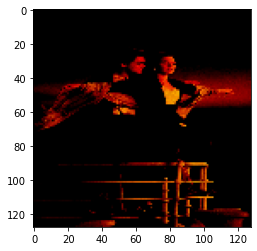

In [12]:
from matplotlib import pyplot
n = 30 #np.random.randint(0,X_train.shape)
#print(X_train[n])
pyplot.imshow(X_train[n])

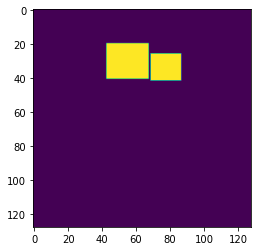

In [13]:
pyplot.imshow(masks[n])

### Q3: Mask detection model:
- Design a face mask detection model.
Hint: Use U-net along with pre-trained transfer learning models
- Design your own Dice Coefficient and Loss function. 
- Train, tune and test the model.
- Evaluate the model using testing data.

In [14]:
from tensorflow.keras import models,layers

In [15]:
input_layer = layers.Input(shape=(128,128,3),name="image_input")

# Encoder Segment
#block1
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block1 = layers.Activation(activation='relu')(x)

#block2
x = layers.MaxPooling2D(pool_size=(2,2))(block1)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block2 = layers.Activation(activation='relu')(x)

#block3
x = layers.MaxPooling2D(pool_size=(2,2))(block2)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block3 = layers.Activation(activation='relu')(x)

#block4
x = layers.MaxPooling2D(pool_size=(2,2))(block3)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block4 = layers.Activation(activation='relu')(x)
block4 = layers.Dropout(0.5)(block4)

## bottleneck
x = layers.MaxPooling2D(pool_size=(2,2))(block4)
x = layers.Conv2D(filters=1024,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=1024,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
bottleneck = layers.Dropout(0.5)(x)

## Decoder segment

#block5
x = layers.Conv2DTranspose(filters=512,kernel_size=(3,3),padding='same',strides=(2,2))(bottleneck)
x = layers.concatenate([x,block4],axis=3)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block5 = layers.Activation(activation='relu')(x)
block5 = layers.Dropout(0.5)(block5)

#block6
x = layers.Conv2DTranspose(filters=256,kernel_size=(3,3),padding='same',strides=(2,2))(block5)
x = layers.concatenate([x,block3],axis=3)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block6 = layers.Activation(activation='relu')(x)

#block7
x = layers.Conv2DTranspose(filters=128,kernel_size=(3,3),padding='same',strides=(2,2))(block6)
x = layers.concatenate([x,block2],axis=3)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block7 = layers.Activation(activation='relu')(x)

#block8
x = layers.Conv2DTranspose(filters=64,kernel_size=(3,3),padding='same',strides=(2,2))(block7)
x = layers.concatenate([x,block1],axis=3)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block8 = layers.Activation(activation='relu')(x)

# outputlayer
output_layer = layers.Conv2D(filters=1,kernel_size=(1,1),activation='softmax')(block8)

#x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

model = models.Model(inputs=input_layer,outputs=output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
	def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [17]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())
	


In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=0.001,amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
model.fit(X_train, masks, epochs = 100, batch_size = 1, validation_split = 0.1,  #splitting 10% of data into validation set                     
                    verbose = 1)   
                    

Epoch 1/100
368/368 [==============================] - 771s 2s/step - loss: 14.9612 - dice_coefficient: 0.2247 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 2/100
368/368 [==============================] - 721s 2s/step - loss: 15.0735 - dice_coefficient: 0.2192 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 3/100
368/368 [==============================] - 710s 2s/step - loss: 15.3326 - dice_coefficient: 0.2025 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 4/100
368/368 [==============================] - 697s 2s/step - loss: 15.2299 - dice_coefficient: 0.2114 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 5/100
368/368 [==============================] - 708s 2s/step - loss: 15.1333 - dice_coefficient: 0.2174 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 6/100
368/368 [==============================] - 2706s 7s/step - loss: 15.0375 - dice_coefficient: 0.2216 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 7/100
368/368 [======

368/368 [==============================] - 516s 1s/step - loss: 15.1660 - dice_coefficient: 0.2160 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 52/100
368/368 [==============================] - 536s 1s/step - loss: 15.1166 - dice_coefficient: 0.2178 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 53/100
368/368 [==============================] - 447s 1s/step - loss: 15.2318 - dice_coefficient: 0.2090 - val_loss: 15.4225 - val_dice_coefficient: 0.1956
Epoch 54/100
286/368 [======================>.......] - ETA: 2:18 - loss: 15.6022 - dice_coefficient: 0.1931

#### Iteration 2:


In [ ]:
optimizer = Adam(lr=0.02,amsgrad=False)
model.compile(optimizer=optimizer, metrics='accuracy',loss='categorical_crossentropy')

In [ ]:
model.fit(X_train, masks, epochs = 10, 
          batch_size = 50, validation_split = 0.1,  #splitting 10% of data into validation set                     
          verbose = 1)

Epoch 1/10
8/8 [==============================] - 495s 61s/step - loss: 83.2635 - accuracy: 0.1341 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 2/10
8/8 [==============================] - 490s 61s/step - loss: 80.5431 - accuracy: 0.1297 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 3/10
8/8 [==============================] - 495s 62s/step - loss: 78.8241 - accuracy: 0.1269 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 4/10
8/8 [==============================] - 495s 61s/step - loss: 78.7482 - accuracy: 0.1268 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 5/10
8/8 [==============================] - 493s 61s/step - loss: 77.7408 - accuracy: 0.1252 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 6/10
8/8 [==============================] - 504s 63s/step - loss: 77.8298 - accuracy: 0.1253 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 7/10
8/8 [==============================] - 508s 63s/step - loss: 77.6240 - accuracy: 0.1250 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 

In [ ]:
model.fit(X_train, masks, epochs = 20,initial_epoch=10, 
          batch_size = 50, validation_split = 0.1,  #splitting 10% of data into validation set                     
          verbose = 1)

Epoch 11/20
8/8 [==============================] - 483s 60s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 12/20
8/8 [==============================] - 481s 60s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 13/20
8/8 [==============================] - 480s 60s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 14/20
8/8 [==============================] - 479s 59s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 15/20
8/8 [==============================] - 481s 60s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 16/20
8/8 [==============================] - 481s 60s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 17/20
8/8 [==============================] - 480s 59s/step - loss: 78.4680 - accuracy: 0.1263 - val_loss: 72.0991 - val_accuracy: 0.1161

#### Iteration 3: RMSPRop

In [ ]:
model.compile(optimizer='rmsprop', metrics='accuracy',loss='categorical_crossentropy')

In [ ]:
model.fit(X_train, masks, epochs = 20, 
          batch_size = 50, validation_split = 0.1,  #splitting 10% of data into validation set                     
          verbose = 1)

Epoch 1/20
8/8 [==============================] - 496s 61s/step - loss: 80.9499 - accuracy: 0.1303 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 2/20
8/8 [==============================] - 487s 60s/step - loss: 82.6835 - accuracy: 0.1331 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 3/20
8/8 [==============================] - 488s 60s/step - loss: 77.6097 - accuracy: 0.1250 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 4/20
8/8 [==============================] - 489s 61s/step - loss: 78.2651 - accuracy: 0.1260 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 5/20
8/8 [==============================] - 487s 60s/step - loss: 78.8731 - accuracy: 0.1270 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 6/20
8/8 [==============================] - 489s 61s/step - loss: 76.7828 - accuracy: 0.1236 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 7/20
8/8 [==============================] - 489s 61s/step - loss: 76.2785 - accuracy: 0.1228 - val_loss: 72.0991 - val_accuracy: 0.1161
Epoch 

#### Q4:Use the “Prediction image” as an input to your designed model and display the output of the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


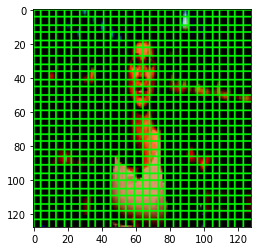

In [ ]:
n = 105

unscaled = X_train[n]

image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > 0.7:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
            cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
            output[y:y2, x:x2] = 1

contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.001 * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.imshow(unscaled)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


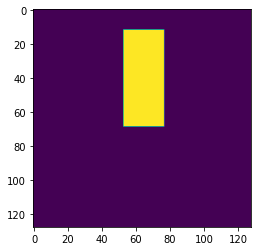

In [ ]:
import matplotlib.pyplot as plt
n = 105
image = X_train[n]

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.3), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)


import matplotlib.pyplot as plt
n = 105
image = masks[n]
plt.imshow(image)

#### Conclusion:
From the above experiments it can be seen that the model is giving better performance with dice coefficient when learning rate is close to 0.001 with Adam as the optimizer

# Project 1 : Task 2:
## DOMAIN: 
Entertainment
## CONTEXT: 
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

#### Q1: You are expected to curate the bounding box co-ordinates for each image. These are also called annotations.

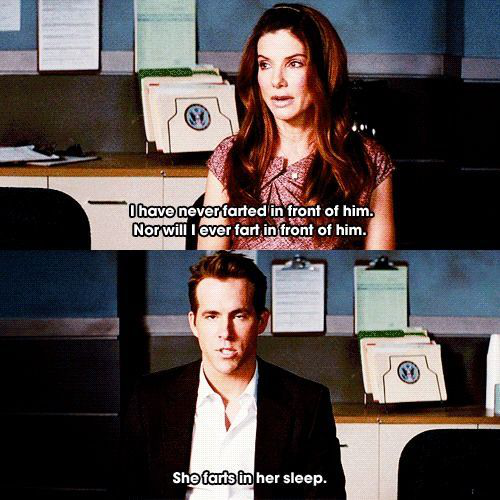

In [10]:
img = tf.keras.preprocessing.image.load_img('Prediction_Image.jpeg')
img

#### Load the pretrained model

In [ ]:
#Get trained model
!wget -q http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz

In [ ]:
!ls -l

total 710352
-rw-r--r-- 1 root root 727390102 Feb 10  2018 mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz
drwxr-xr-x 1 root root      4096 May  6 13:44 sample_data


In [ ]:
#Unzip the file
!tar -xf mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz

In [ ]:
#check the unzipped files in the folder
!ls -l mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28

total 524872
-rw-r--r-- 1 345018 5000        77 Feb  1  2018 checkpoint
-rw-r--r-- 1 345018 5000 266873310 Feb  1  2018 frozen_inference_graph.pb
-rw-r--r-- 1 345018 5000 260030748 Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 345018 5000     43391 Feb  1  2018 model.ckpt.index
-rw-r--r-- 1 345018 5000  10496629 Feb  1  2018 model.ckpt.meta
-rw-r--r-- 1 345018 5000      3811 Feb  1  2018 pipeline.config
drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 saved_model


In [ ]:
!ls -l mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/saved_model

total 261292
-rw-r--r-- 1 345018 5000 267553754 Feb  1  2018 saved_model.pb
drwxr-xr-x 2 345018 5000      4096 Feb  1  2018 variables


In [ ]:
#In tf2, we will use saved model rather than frozen_inference_graph.pb
model = tf.saved_model.load('mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/saved_model')
model = model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
#Check model's input
model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

Here the model input tensor's name is 'image_tensor' and it has a 4D shape (first dimension is for batch size i.e how many images we will feed).

In [ ]:
#Check model's output tensors
model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_masks:0' shape=(None, None, None, None) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

#### Load Class labels

Label dictionary (class index to class name mapping) should be taken from training module. Here is the dictionary which was used for this model.

In [ ]:
all_classes = {1 : 'person' , 2: 'bicycle' , 3: 'car' , 4: 'motorcycle' , 5: 'airplane' , 6: 'bus' , 7: 'train' , 
               8: 'truck' , 9: 'boat' , 10: 'traffic light' , 11: 'fire hydrant' , 13: 'stop sign' , 14: 'parking meter' , 
               15: 'bench' , 16: 'bird' , 17: 'cat' , 18: 'dog' , 19: 'horse' , 20: 'sheep' , 21: 'cow' , 22: 'elephant' , 
               23: 'bear' , 24: 'zebra' , 25: 'giraffe' , 27: 'backpack' , 28: 'umbrella' , 31: 'handbag' , 32: 'tie' , 
               33: 'suitcase' , 34: 'frisbee' , 35: 'skis' , 36: 'snowboard' , 37: 'sports ball' , 38: 'kite' , 
               39: 'baseball bat' , 40: 'baseball glove' , 41: 'skateboard' , 42: 'surfboard' , 43: 'tennis racket' , 
               44: 'bottle' , 46: 'wine glass' , 47: 'cup' , 48: 'fork' , 49: 'knife' , 50: 'spoon' , 51: 'bowl' , 
               52: 'banana' , 53: 'apple' , 54: 'sandwich' , 55: 'orange' , 56: 'broccoli' , 57: 'carrot' , 58: 'hot dog' , 
               59: 'pizza' , 60: 'donut' , 61: 'cake' , 62: 'chair' , 63: 'couch' , 64: 'potted plant' , 65: 'bed' , 
               67: 'dining table' , 70: 'toilet' , 72: 'tv' , 73: 'laptop' , 74: 'mouse' , 75: 'remote' , 76: 'keyboard' , 
               77: 'cell phone' , 78: 'microwave' , 79: 'oven' , 80: 'toaster' , 81: 'sink' , 82: 'refrigerator' , 
               84: 'book' , 85: 'clock' , 86: 'vase' , 87: 'scissors' , 88: 'teddy bear' , 89: 'hair drier' , 90: 'toothbrush'}

In [ ]:
all_classes[15]

'bench'

#### Model Prediction

In [ ]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height, image_width):
  """
  Code taken from TensorFlow Object Detection API --> utils/visualization_utils.py 
  Transforms the box masks back to full image masks.
  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.
  Args:
    box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
  Returns:
    A tf.float32 tensor of size [num_masks, image_height, image_width].
  """
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
      boxes = tf.reshape(boxes, [-1, 2, 2])
      min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
      max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
      transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
      return tf.reshape(transformed_boxes, [-1, 4])

    box_masks_expanded = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks_expanded)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
    return tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reverse_boxes,
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        extrapolation_value=0.0)
  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], dtype=tf.float32))
  return tf.squeeze(image_masks, axis=3)

In [ ]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    w, h = img.size
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]
    detection_masks = output['detection_masks'].numpy()[0]
    
    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]
    selected_prediction_masks = detection_masks[selected_predictions]

    #Resize masks to image size
    detection_masks_reframed = reframe_box_masks_to_image_masks(selected_prediction_masks, 
                                                                selected_prediction_boxes,
                                                                h, w)
    #Make it a binary array (1 - pixel belongs to object)
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(all_classes[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes, 
            'Masks': detection_masks_reframed}

Let's download couple of images for which we will do predictions.

In [ ]:
!ls -l

total 710408
drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28
-rw-r--r-- 1 root   root 727390102 Feb 10  2018 mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz
-rw-r--r-- 1 root   root     52325 May 11 06:10 Prediction_Image.jpeg
drwxr-xr-x 1 root   root      4096 May  6 13:44 sample_data


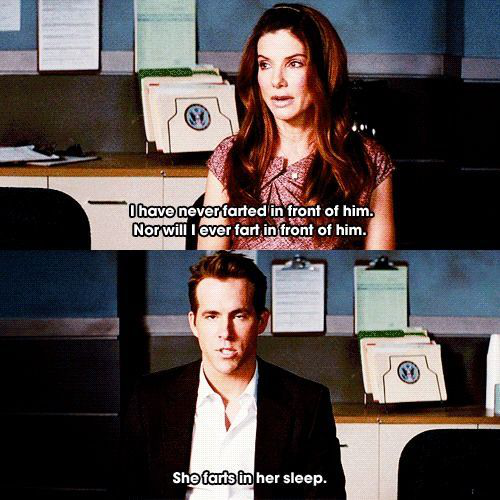

In [ ]:
tf.keras.preprocessing.image.load_img('/content/Prediction_Image.jpeg')

In [ ]:
#Model predictions for image1.jpg
detector_prediction('/content/Prediction_Image.jpeg')

{'Box coordinates': array([[252, 126, 490, 345],
        [  2, 190, 256, 401],
        [ 76, 137, 154, 237]]),
 'Classes': ['person', 'person', 'microwave'],
 'Masks': <tf.Tensor: shape=(3, 500, 500), dtype=uint8, numpy=
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)>,
 'Scores': array([0.99583155, 0.9890371 , 0.5221609 ], dtype=float32),
 'Total Predictions': 3}

#### Visualizing Model Prediction

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def visualize_output(image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)

    #Read image
    img = cv2.imread(image_file)
    
    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):

        #Mask
        mask = output['Masks'][i]

        #Draw mask
        colored_mask = np.expand_dims(mask, axis=2) * np.reshape([255, 255, 0], (1,1,3))
        img = cv2.addWeighted(colored_mask.astype('uint8'), 0.5, img, 1.0, 0.0)

        #Bounding box
        box = output['Box coordinates'][i]
        
        #Draw rectangle 
        img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 2)
        
        #Add Label - Class name and confidence level
        label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.show()

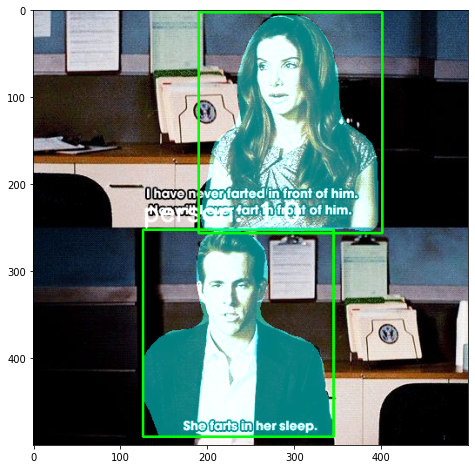

In [ ]:
#Visualize first image
visualize_output('/content/Prediction_Image.jpeg', confidence_threshold=0.9)

#### Conclusion:
Using the pre-trained model for bounding box detection helps alot. The model which is used is mask RCNN Inception Resnet v2, which is trained on coco dataset.
As can be seen there are 90 classes identified. This model clearly identifies the bounding boxes and can be used for automation of face detection.